In [1]:
import numpy as np
from matplotlib import pyplot as plt 
from statistics import median
%matplotlib inline
import os
from prettytable import PrettyTable

In [19]:
def moving_avg(array, window_size):
    back = int(np.ceil(window_size))
    forward = int(np.floor(window_size))
    return [np.mean(array[max(0,i-back):i+forward]) for i in range(len(array))]

In [53]:
files = [['no_storage', 'baseline_no_storage'],['rand_diurnal' , 'baseline_rand_diurnal'],['fixed_rbc_agents', 'baseline_fixed_rbc']]

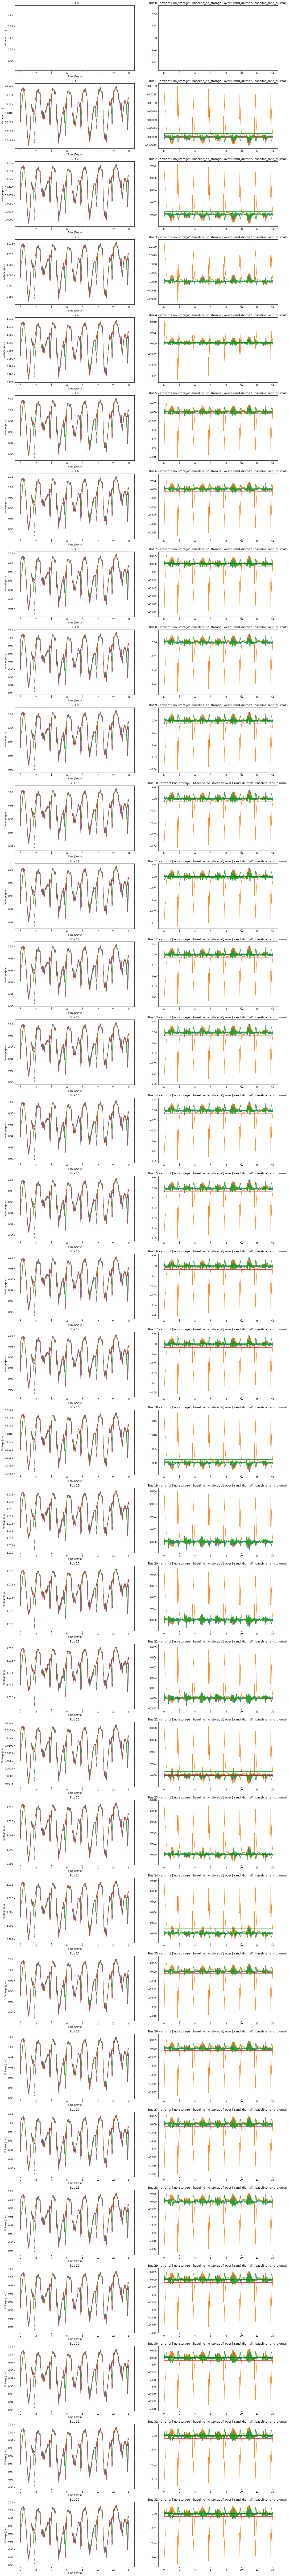

In [67]:
improved_buses = []
fig, ax = plt.subplots(33,2 ,figsize=(20,200))

x = np.arange(2689) / 24 / 4 / 2
for pair in files:
    diff = []
    improved = 0
    for j in range(2):
        file = pair[j]
        data = np.genfromtxt(f'models/{file}/voltage.csv', delimiter=',')
        diff += [data]
        for i in range(33):
            ax[i][0].plot(x, data[:,i])
            ax[i][0].set_xlabel("Time (Days)")
            ax[i][0].set_ylabel("Voltage (p.u.)")
            ax[i][0].set_title(f"Bus {i}")
    for i in range(33):
        improvement = abs(diff[1][:,i]-1) - abs(diff[0][:,i]-1)
        mean = np.mean(improvement)
        if mean >= 0:
            c = 'g'
        else:
            c = 'r'
            improved += 1
        ax[i][1].plot(np.linspace(0,14,len(improvement)), improvement)
        ax[i][1].plot([0,14], mean*np.ones(2), color=c)
        ax[i][1].set_title(f"Bus {i} - error of {files[0]} over {files[1]}")
    improved_buses += [improved,0]

plt.show()

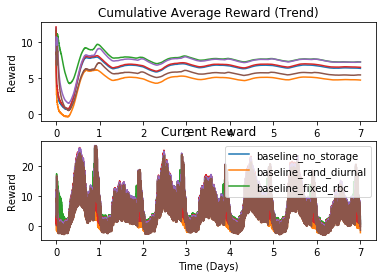

In [68]:
fig, ax = plt.subplots(2 )
legend = []
# headers = ['file name', 'tot. reward']
# headers += ['', for file in files]
t = PrettyTable(['File Name', 'Reward', 'n Impr', '% Impr'])

for pair in files:
    rewards = []
    rows = []
    for file in pair:
        reward = np.genfromtxt(f'models/{file}/reward.csv', delimiter=',')
        ax[0].plot(np.linspace(0,7,len(reward)), np.divide(np.cumsum(reward), np.arange(len(reward))+1))
        ax[1].plot(np.linspace(0,7,len(reward)), reward)
        [foo.set_xlabel('Time (Days)') for foo in ax]
        [foo.set_ylabel('Reward') for foo in ax]
        ax[0].set_title("Cumulative Average Reward (Trend)")
        ax[1].set_title("Current Reward")
        rewards += [sum(reward)]
        rows += [[file, rewards[-1], improved_buses.pop()]]
    rows[0] += [(rewards[0]-rewards[-1])/rewards[0]]
    rows[1] += [0]
    for row in rows:
        t.add_row(row)
    legend += [file]
plt.legend(legend)

In [69]:
print(t)

+-----------------------+--------------------+--------+---------------------+
|       File Name       |       Reward       | n Impr |        % Impr       |
+-----------------------+--------------------+--------+---------------------+
|       no_storage      | 17145.255555833603 |   0    | 0.25379551670127093 |
|  baseline_no_storage  | 12793.866563065478 |   4    |          0          |
|      rand_diurnal     | 19525.89153784782  |   0    | 0.10141364282555874 |
| baseline_rand_diurnal | 17545.69974757792  |   21   |          0          |
|    fixed_rbc_agents   | 19503.93279636321  |   0    | 0.24600878907006316 |
|   baseline_fixed_rbc  | 14705.793907026005 |   7    |          0          |
+-----------------------+--------------------+--------+---------------------+


In [39]:
n_homes = np.nan
for file in files:
    len_files = len(os.listdir(f'models/{file}/homes'))
    if len_files > n_homes or len_files < n_homes:
        print("Warning: The number of RL controlled homes is not the same for these files.")
    else:
        n_homes = len_files


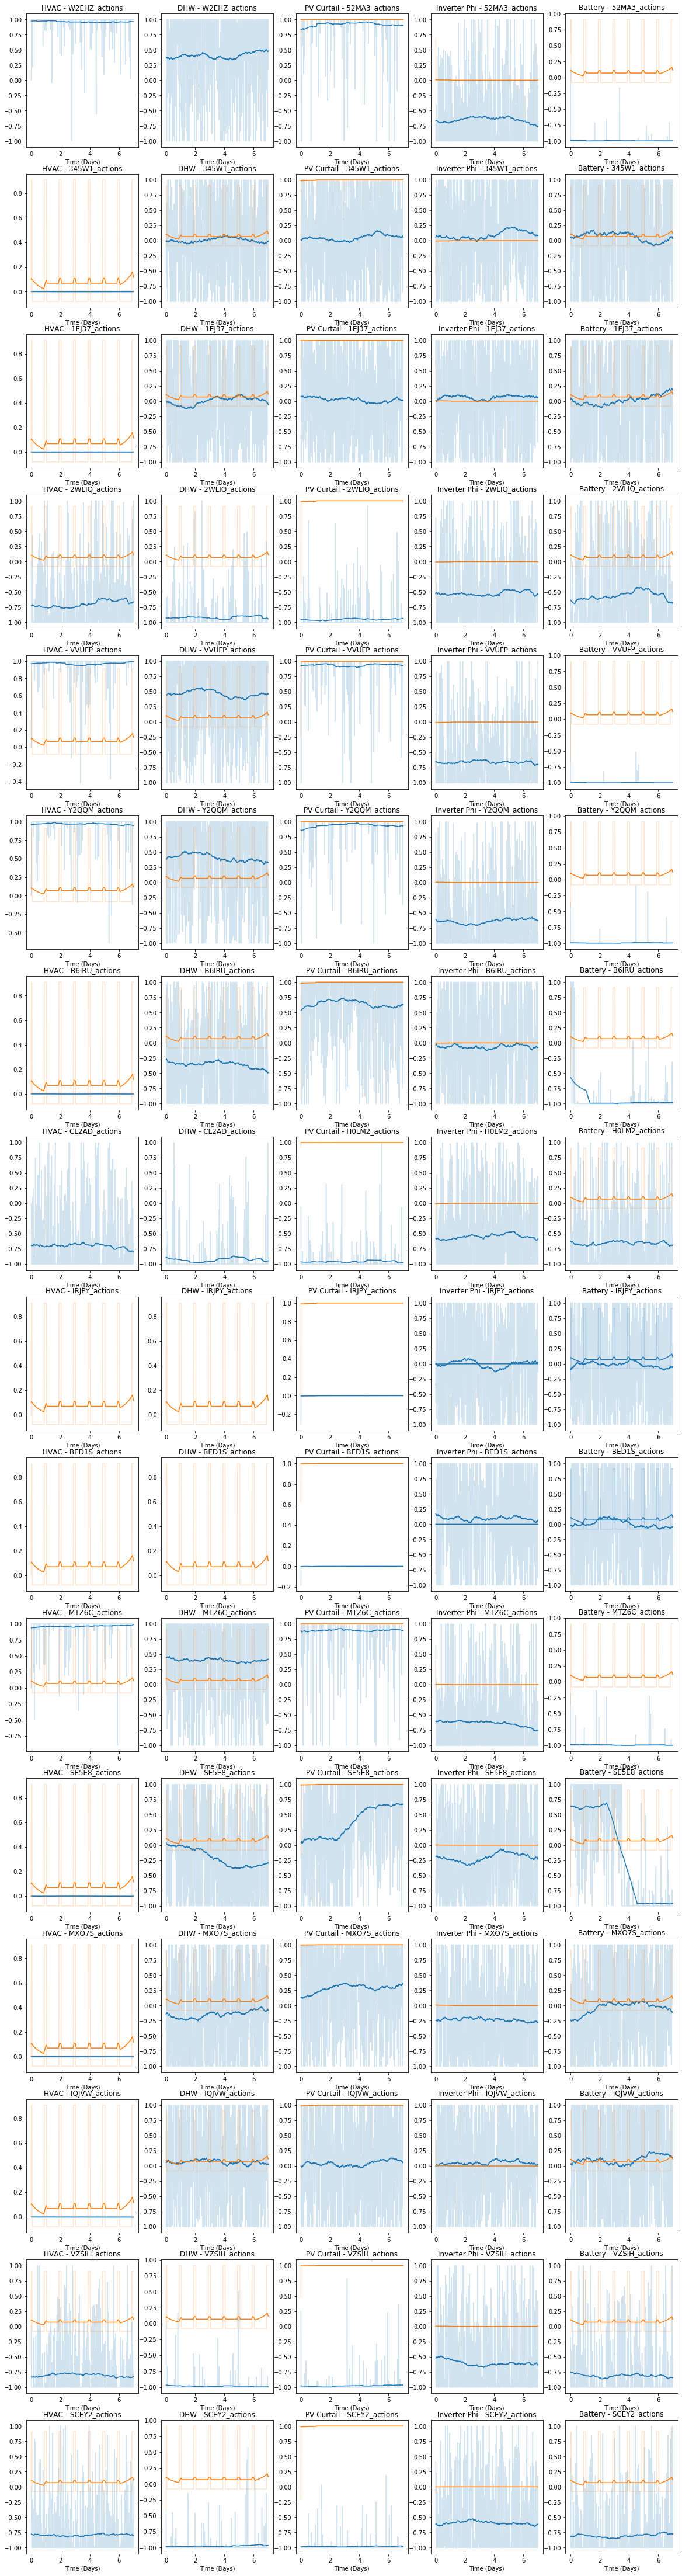

In [40]:
action_order = ['HVAC', 'DHW', 'PV Curtail', 'Inverter Phi', 'Battery']
fig, ax = plt.subplots(n_homes, 5, figsize=(20,80))

for file in files:
    homes = os.listdir(f'models/{file}/homes')
    for h in range(len(homes)):
        home = homes[h]
        actions = np.genfromtxt(f'models/{file}/homes/{home}', delimiter=',')
        for a in range(actions.shape[1]):
            if actions.shape[1] == 3:
                offset = 2
            else:
                offset = 0
            c = ax[h][a]._get_lines.get_next_color()
            ax[h][a+offset].plot(np.linspace(0,7,actions.shape[0]), moving_avg(actions[:,a], 100), color=c)
            ax[h][a+offset].plot(np.linspace(0,7,actions.shape[0]), actions[:,a], color=c, alpha=0.2)
            ax[h][a+offset].set_xlabel("Time (Days)")
            ax[h][a+offset].set_title(f"{action_order[a+offset]} - {home[:-4]}")